## 3. Training the CRC detection models based on MEGMA Fmaps 

Now that we have fitted the `megma` object for the Fmaps generation, we can train the CRC detection models based on these transformed Fmaps. We are going to use the convolutional neural network (CNN) based AggMapNet to train the Fmaps. AggMapNet is a simple yet efficient network architecture for low-sample size data, it has fewer trainable parameters and early-stopping strategy to stop from overfitting.

[3.1 Training & test AggMapNet on overall MEGMA Fmaps](#3.1-Training-and-test-AggMapNet-on-overall-MEGMA-Fmaps)



[3.2 Training and test AggMapNet on country specific MEGMA Fmaps](#3.2-Training-and-test-AggMapNet-on-country-specific-MEGMA-Fmaps)

[3.3 Comparing the STST performance and discussion](#3.3-Comparing-the-STST-performance-and-discussion)

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc as calculate_auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

np.random.seed(666) #just for reaptable results

In [9]:
## AggMapNet parameters
epochs = 30 #number of epochs
lr = 1e-4 #learning rate
batch_size = 1 #batch size
conv1_kernel_size = 7 #kernal size of the first cnn layer
gpuid = 1 #use which gpu to train the model



def train(megma, train_country,  model_save_dir):
    
    ## data process parameters
    minv = 1e-8 #minimal value for log-transform
    scale_method = 'standard' #data scaling method
    url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
    
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % train_country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    dfy = pd.read_csv(url + '%s_dfy.csv' % train_country, index_col='Sample_ID')

    X = megma.batch_transform(dfx_vector.values, 
                              scale_method = scale_method)
    Y = pd.get_dummies(dfy.Group).values
    
    # fit AggMapNet
    clf = AggMapNet.MultiClassEstimator(epochs = epochs,  
                                        batch_size = batch_size, 
                                        lr = lr, 
                                        conv1_kernel_size = conv1_kernel_size,
                                        gpuid = gpuid,
                                        verbose = 0)
    clf.fit(X, Y)
    
    
    ## save supervised AggMapNet model
    model_save_name = os.path.join(model_save_dir, 'aggmapnet.%s' % train_country)
    clf.save_model(model_save_name)

    return clf


def test(clf, megma, test_country):
    
    ## data process parameters
    minv = 1e-8 #minimal value for log-transform
    scale_method = 'standard' #data scaling method
    url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
    
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % test_country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + minv)
    dfy = pd.read_csv(url + '%s_dfy.csv' % test_country, index_col='Sample_ID')
    testX = megma.batch_transform(dfx_vector.values, 
                                  scale_method = scale_method)
    testY = pd.get_dummies(dfy.Group).values 
    y_true = testY[:,0]
    y_pred = clf.predict(testX)[:,0] 
    y_score = clf.predict_proba(testX)[:,0]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / sum([tn, fp, fn, tp])
    sensitivity = tp / sum([tp, fn])
    specificity = tn / sum([tn, fp])
    roc_auc = roc_auc_score(y_true, y_score)
    precision = tp / sum([tp, fp])
    recall =  tp / sum([tp, fn]) #equals to sensitivity
    
    res = {'test_country':test_country,
           'accuracy':acc, 
           'roc_auc':roc_auc,
           'sensitivity': sensitivity, 
           'specificity': specificity,
           'precision':precision,
           'recall':recall}
    return res

def get_non_diag_mean(df):
    v = df.values.copy()
    np.fill_diagonal(v, np.nan)
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean,std

### 3.1 Training and test AggMapNet on overall MEGMA Fmaps

In this section, we will introduce how to employ the CNN-based AggMapNet to train CRC detection models based on the `megma_all` generated **2D-microbiomeprints (Fmaps)**. The CRC dection model is a classfication model because we have the binary labels (CRCs or CTRs) in our data. Same as the Fmaps generation, we can use the study to stduy transfer(STST) method to test the performance of our model.

Please be Noted that in the STST experiment, the Fmaps can be transformed by a country-specific `megma` (fitted or trained by one country unlabelled metagenomic data, such as `megma_usa`) or an overall `megma` (fitted or trained by all unlabelled metagenomic data, i.e., the `megma_all`), becuase **MEGMA** is an unsupervised learning method and only needs to be fitted on the unlabelled data.

First of all, let's try to explore the STST model performance on the Fmaps transformed by an overall `megma_all` . Specifically, we are going to train the CRC classficaition model `AggMapNet` (supervised model) based the Fmaps that generated by `megma_all` (unsupervised model). We will train the CRC detection model based on one country data and test the model performance on the rest of the countries.

In [10]:
save_dir = './megma_overall_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# load the pre-fitted megma_all object
megma = loadmap('./megma/megma.all')

countries = ['USA', 'CHN', 'DEU', 'FRA', 'AUS', ] 
all_res1 = []
for train_country in countries:
    clf = train(megma, train_country, save_dir,)
    # Test model performance using STST strategy
    for test_country in countries:
        res = test(clf, megma, test_country)
        res.update({'train_country':train_country})
        all_res1.append(res)

df1 = pd.DataFrame(all_res1)
dfres1 = pd.crosstab(index = df1.train_country, 
                    columns= df1.test_country, 
                    values= df1.roc_auc, 
                    aggfunc = np.mean)

100%|#################################################################################| 104/104 [00:01<00:00, 57.13it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_overall_model/aggmapnet.USA


100%|###############################################################################| 128/128 [00:00<00:00, 1937.72it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_overall_model/aggmapnet.CHN


100%|###############################################################################| 120/120 [00:00<00:00, 1565.51it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_overall_model/aggmapnet.DEU


100%|###############################################################################| 114/114 [00:00<00:00, 2403.50it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_overall_model/aggmapnet.FRA


100%|###############################################################################| 109/109 [00:00<00:00, 1886.13it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_overall_model/aggmapnet.AUS


100%|###############################################################################| 109/109 [00:00<00:00, 2175.88it/s]


### 3.2 Training and test AggMapNet on country specific MEGMA Fmaps

In this section, we will introduce how to employ the CNN-based AggMapNet to train CRC detection models using the country-specific `megma` generated **2D-microbiomeprints (Fmaps)**. 

Specifically, we are going to use one country data to fit `megma` and `aggmapnet`, then we test the model performance on the rest of the countries. For example, if we trained the CRC detection model based on the USA data, we are going to use the `megma_usa` to transform the Fmaps for all of the countries, i.e., the country-specific megma will be used. Save as above model evaluation, we will train the AggMapNet-based CRC detection model on one country data (label data and abundance data) and test the model performance on the rest of the countries.

In [11]:
save_dir = './megma_country_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_res2 = []
for train_country in countries:

    # load the pre-fitted megma object., such as `megma_usa`.
    megma = loadmap('./megma/megma.%s' % train_country) 
    
    clf = train(megma, train_country, save_dir)

    # Test model performance using STST strategy
    for test_country in countries:
        res = test(clf, megma, test_country)
        res.update({'train_country':train_country})
        all_res2.append(res)

df2 = pd.DataFrame(all_res2)
dfres2 = pd.crosstab(index = df2.train_country, 
                    columns= df2.test_country, 
                    values= df2.roc_auc, 
                    aggfunc = np.mean)

100%|###############################################################################| 104/104 [00:00<00:00, 2268.13it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_country_model/aggmapnet.USA


100%|###############################################################################| 128/128 [00:00<00:00, 1946.63it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_country_model/aggmapnet.CHN


100%|###############################################################################| 120/120 [00:00<00:00, 1070.05it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_country_model/aggmapnet.DEU


100%|###############################################################################| 114/114 [00:00<00:00, 2088.69it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_country_model/aggmapnet.FRA


100%|###############################################################################| 109/109 [00:00<00:00, 1987.70it/s]


MultiClassEstimator(batch_norm=False, batch_size=1, conv1_kernel_size=7,
                    dense_avf='relu', dense_layers=[128], dropout=0.0,
                    epochs=30, gpuid='1', last_avf='softmax',
                    loss='categorical_crossentropy', lr=0.0001, metric='ACC',
                    monitor='val_loss', n_inception=2,
                    name='AggMap MultiClass Estimator', patience=10000,
                    random_state=32, verbose=0)
saving model to ./megma_country_model/aggmapnet.AUS


100%|###############################################################################| 109/109 [00:00<00:00, 1904.41it/s]


### 3.3 Comparing the STST performance and discussion

Now, let's compare the ROC-AUC performance of CRC detection model that trained on the Fmaps generated by overall `megma` and country-specific `megma`. We can see that the `megma_all` shows better performance than the country specific ones.

This means that the Fmaps generated by `megma_all` have a more reasonable feature arrangement and combination than country-specific `megma`, and using these `megma_all` Fmaps to train the detection model will achieve better performance. This result is consistent with our previous discussion: `megma` shows better performance under large sample fitting. Since the fitting of `megma` only requires unlabeled data, in practice we can use a large amount of unlabeled data to pre-train `megma`, which is very helpful to the model performance.

If the unlabeled data used to fit the `megma` is still limited, we can also adjust the `var_thr` parameter in the fitting stage of `megma` to make the generated Fmaps more structured. In this example, we used `var_thr = 3` to fit the country-specific `megma` for each country, but this value can be adjusted in each country, and we believe that under a larger value, such as 10, better roc-auc performances will be achieved.

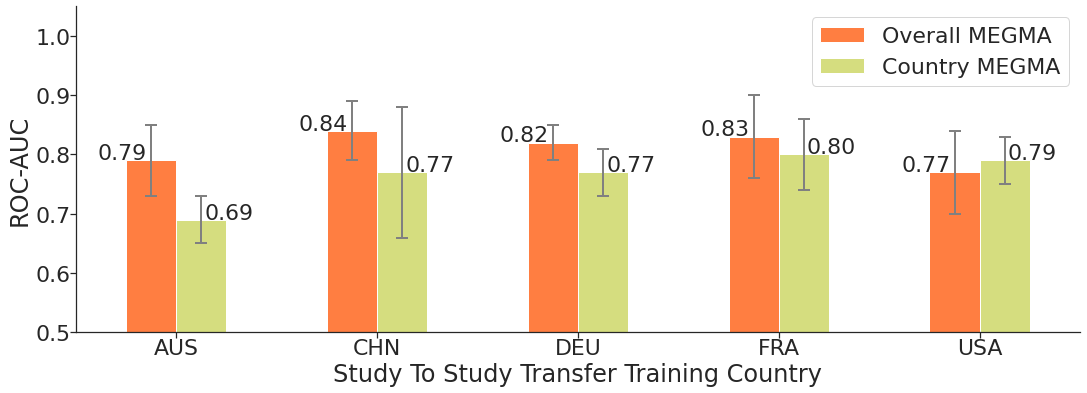

In [12]:
sns.set(style = 'white', font_scale=2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6), sharex = True, sharey = True)

y1 = get_non_diag_mean(dfres1)[0].to_frame(name = 'Overall MEGMA')
y2 = get_non_diag_mean(dfres2)[0].to_frame(name = 'Country MEGMA')

y1_err = get_non_diag_mean(dfres1)[1].to_frame(name = 'Overall MEGMA')
y2_err = get_non_diag_mean(dfres2)[1].to_frame(name = 'Country MEGMA')

y = y1.join(y2)
y_err = y1_err.join(y2_err)

color = sns.color_palette("rainbow_r", 5) #PiYG

y.plot(kind = 'bar',ax = ax, color = color, yerr= y_err,ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
#ax.set_title('Study To Study Transfer (STST) Average Performance')
ax.set_xlabel('Study To Study Transfer Training Country')

for x_, y_ in enumerate(y['Overall MEGMA'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.39, y_+0.002), fontsize =22)

for  x_, y_ in enumerate(y['Country MEGMA'].values):
    ax.annotate('%.2f' % y_, xy = (x_+0.14, y_+0.002), fontsize =22)
    
ax.set_xticklabels(labels = y.index,rotation=0, ha = 'center')
ax.set_ylim(0.5,1.05)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)

fig.savefig('./images/STST_megma_all_vs_megma_country.pdf', bbox_inches='tight', dpi=400) 

* For overall megma, we can see that the model trained on the `megma_all` generated **USA** Fmaps shows worst performance (STST average roc-auc: 0.77, i.e., the model performance on the rest countries).
* For country-specific megma, we can see that the model trained on the `megma_AUS` generated **AUS** Fmaps shows worst performance (STST average roc-auc: 0.69). This means that the `megma` fitted by **AUS** abundance data is not good enough. It is likely that the abundance data of AUS is relatively special, and the sample size is too small to present the global and intrinsic correlation between microorganisms, resulting in a biased arrangement of the 2D map.


In next section, we will explain the model trained on the Fmaps generated by overall `megma` and country-specific `megma`. We can identify the important microbes that contribute to the model prediction, and generate the saliency map using the global feature importance and the microbe 2D postions in `megma` object.

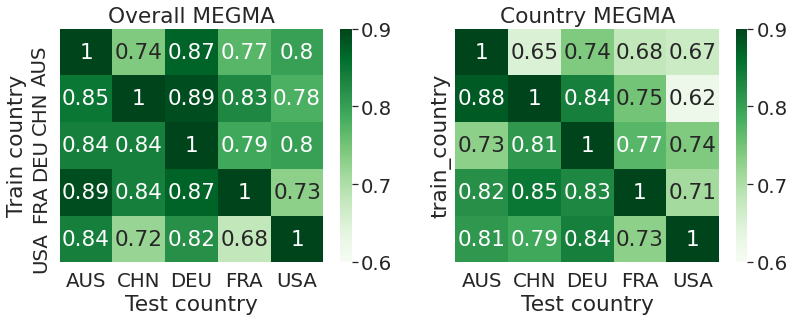

In [20]:
sns.set(style = 'white', font_scale=1.8)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4.3), sharex=True, sharey=True)

ax1, ax2 = axes

sns.heatmap(dfres1.round(2), cmap = 'Greens',  ax = ax1, annot=True,  vmin = 0.6, vmax = 0.9,)
ax1.set_title("Overall MEGMA")

sns.heatmap(dfres2.round(2), cmap = 'Greens',  ax = ax2, annot=True, vmin = 0.6, vmax = 0.9,)
ax2.set_title("Country MEGMA")

ax1.set_ylabel('Train country')
# ax2.set_ylabel('Train country')

ax1.set_xlabel('Test country')
ax2.set_xlabel('Test country')

fig.savefig('./images/STST_roc_megma_all_vs_megma_country.png', bbox_inches='tight', dpi=400)
fig.savefig('./images/STST_roc_megma_all_vs_megma_country.pdf', bbox_inches='tight', dpi=400)

In [19]:
dfres1.to_csv('./images/STST_ROC_megma_all.csv')
dfres2.to_csv('./images/STST_ROC_megma_specific.csv')